In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import glob
from tqdm import tqdm

# Internal modules
from logger import logger
from constants import *
from parsers import get_info_table
from fileops import get_data_root, get_output_equivalent, get_data_folders, loadtif
from postpro import process_runids
from plotters import harmonize_axes_limits
from substitutors import StackSubstitutor

### Input parameters

In [141]:
# Get input data directory
dataroot = get_data_root()  # Root directory for raw data
submap = [
    (1, 0, None),
    (FrameIndex.STIM - 1, FrameIndex.STIM, NFRAMES_PER_TRIAL),
]
ss = StackSubstitutor(submap)
datadir = os.path.join(
    get_output_equivalent(dataroot, DataRoot.RAW, DataRoot.SUBSTITUTED),
    ss.code,
    'main'
)
logger.info(f'input data directory: "{datadir}"')

# Define input parameters
projfunc = 'median'  # Projection function to get reference image from 3D stack
sortkey = Label.RUNID  # Sort key for different files in the same dataset folder
lines = [  # Lines to analyze
    'pv', 
    'sst', 
    'line3',
]

 2023/10/27 17:03:42: input data directory: "/gpfs/scratch/lemait01/data/usnm/substituted/submap_0<-1_9->10every100/main"


### Derived parameters

In [ ]:
projfunc = {'mean': np.mean, 'median': np.median}[projfunc]

### Extract reference frame pixel distributions across lines, datasets, and runs 

In [151]:
def extract_reference_distribution(fpath, projfunc, verbose=True):
    '''
    Extract pixel intensity distribution from reference image of a TIF file.

    :param fpath: Path to tif file.
    :param projfunc: Projection function to get reference image from 3D stack.
    :param verbose: Whether to print verbose output.
    :return: Reference distribution as pandas Series.
    '''
    # Load tif stack
    stack = loadtif(fpath, verbose=verbose)
    # Compute reference image 
    refimg = projfunc(stack, axis=0)
    # Create series from serialized pixel distribution
    refdist = pd.Series(refimg.ravel(), name='intensity')
    refdist.index.name = 'pixel'
    # Return reference distribution
    return refdist


def extract_reference_distributions(folder, *args, **kwargs):
    '''
    Extract reference distributions from all TIF files in a folder

    :param folder: Path to folder containing TIF files.
    :return: Reference distributions as multi-indexed pandas Series.
    '''
    # Check if reference distributions have already been extracted
    output_fpath = os.path.join(folder, f'{projfunc.__name__}_refdists.csv') 

    # If so, load them
    if os.path.exists(output_fpath):
        logger.info(f'loading reference distributions from {os.path.basename(folder)} folder')
        refdists = pd.read_csv(output_fpath, index_col=['file', 'pixel'])['intensity']

    # Otherwise, extract and save them
    else:
        logger.info(f'extracting stack {projfunc.__name__} projection images from {os.path.basename(folder)} folder')
        fpaths = glob.glob(os.path.join(folder, '*.tif'))
        fnames = [os.path.basename(fpath) for fpath in fpaths]
        refdists = []
        for fpath in tqdm(fpaths):
            refdists.append(
                extract_reference_distribution(fpath, *args, verbose=False, **kwargs))
        refdists = pd.concat(
            refdists, axis=0, keys=fnames, names=['file'])
        logger.info(f'saving reference distributions to {os.path.basename(folder)} folder')
        refdists.to_csv(output_fpath)
    
    # Return reference distributions
    return refdists


# Loop over lines
ref_dists = []
for line in lines:
    # Get dataset folders in line subdirectory
    linedir = os.path.join(datadir, line)
    dataset_folders = get_data_folders(linedir)
    datasets = [os.path.basename(df) for df in dataset_folders]

    # Extract reference distributions from all datasets in line
    ref_dists.append(pd.concat(
        [extract_reference_distributions(folder, projfunc) for folder in dataset_folders],
        axis=0, keys=datasets, names=[Label.DATASET]
    ))

# Concatenate reference distributions from all lines
ref_dists = pd.concat(ref_dists, axis=0, keys=lines, names=[Label.LINE])
ref_dists    

 2023/10/27 17:18:36: Searching through /gpfs/scratch/lemait01/data/usnm/substituted/submap_0<-1_9->10every100/main/pv
 2023/10/27 17:18:36: found 10 folders containing TIF files
 2023/10/27 17:18:36: extracting stack mean projection images from 20190702_mouse1_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]

 2023/10/27 17:18:40: saving reference distributions to 20190702_mouse1_region1 folder


 2023/10/27 17:18:44: extracting stack mean projection images from 20190703_mouse4_region1 folder


100%|██████████| 16/16 [00:04<00:00,  3.85it/s]

 2023/10/27 17:18:49: saving reference distributions to 20190703_mouse4_region1 folder


 2023/10/27 17:18:54: extracting stack mean projection images from 20190629_mouse2_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]

 2023/10/27 17:18:58: saving reference distributions to 20190629_mouse2_region1 folder


 2023/10/27 17:19:02: extracting stack mean projection images from 20190702_mouse5_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

 2023/10/27 17:19:06: saving reference distributions to 20190702_mouse5_region1 folder


 2023/10/27 17:19:10: extracting stack mean projection images from 20190630_mouse3_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

 2023/10/27 17:19:14: saving reference distributions to 20190630_mouse3_region1 folder


 2023/10/27 17:19:18: extracting stack mean projection images from 20190821_mouse3_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

 2023/10/27 17:19:22: saving reference distributions to 20190821_mouse3_region1 folder


 2023/10/27 17:19:27: extracting stack mean projection images from 20190821_mouse6_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]

 2023/10/27 17:19:31: saving reference distributions to 20190821_mouse6_region1 folder


 2023/10/27 17:19:35: extracting stack mean projection images from 20190606_mouse2_region1 folder


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

 2023/10/27 17:19:38: saving reference distributions to 20190606_mouse2_region1 folder


 2023/10/27 17:19:40: extracting stack mean projection images from 20190821_mouse7_region1 folder


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]

 2023/10/27 17:19:45: saving reference distributions to 20190821_mouse7_region1 folder


 2023/10/27 17:19:49: extracting stack mean projection images from 20190606_mouse2_region2 folder


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

 2023/10/27 17:19:51: saving reference distributions to 20190606_mouse2_region2 folder


 2023/10/27 17:19:56: Searching through /gpfs/scratch/lemait01/data/usnm/substituted/submap_0<-1_9->10every100/main/sst
 2023/10/27 17:19:56: found 17 folders containing TIF files
 2023/10/27 17:19:56: extracting stack mean projection images from 20190513_mouse2_region1 folder


100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

 2023/10/27 17:19:59: saving reference distributions to 20190513_mouse2_region1 folder


 2023/10/27 17:20:02: extracting stack mean projection images from 20190808_mouse6_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

 2023/10/27 17:20:05: saving reference distributions to 20190808_mouse6_region1 folder


 2023/10/27 17:20:10: extracting stack mean projection images from 20190514_mouse1_region1 folder


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

 2023/10/27 17:20:13: saving reference distributions to 20190514_mouse1_region1 folder


 2023/10/27 17:20:16: extracting stack mean projection images from 20190511_mouse7_region2 folder


100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

 2023/10/27 17:20:19: saving reference distributions to 20190511_mouse7_region2 folder


 2023/10/27 17:20:22: extracting stack mean projection images from 20190514_mouse1_region2 folder


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

 2023/10/27 17:20:24: saving reference distributions to 20190514_mouse1_region2 folder


 2023/10/27 17:20:27: extracting stack mean projection images from 20190513_mouse2_region2 folder


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

 2023/10/27 17:20:30: saving reference distributions to 20190513_mouse2_region2 folder


 2023/10/27 17:20:33: extracting stack mean projection images from 20190701_mouse1_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]

 2023/10/27 17:20:37: saving reference distributions to 20190701_mouse1_region1 folder


 2023/10/27 17:20:41: extracting stack mean projection images from 20190706_mouse7_region1 folder


100%|██████████| 14/14 [00:03<00:00,  3.68it/s]

 2023/10/27 17:20:45: saving reference distributions to 20190706_mouse7_region1 folder


 2023/10/27 17:20:49: extracting stack mean projection images from 20190510_mouse6_region1 folder


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

 2023/10/27 17:20:52: saving reference distributions to 20190510_mouse6_region1 folder


 2023/10/27 17:20:55: extracting stack mean projection images from 20190516_mouse8_region1 folder


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

 2023/10/27 17:20:57: saving reference distributions to 20190516_mouse8_region1 folder


 2023/10/27 17:21:00: extracting stack mean projection images from 20190510_mouse6_region2 folder


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

 2023/10/27 17:21:03: saving reference distributions to 20190510_mouse6_region2 folder


 2023/10/27 17:21:06: extracting stack mean projection images from 20190628_mouse2_region1 folder


100%|██████████| 14/14 [00:03<00:00,  3.94it/s]

 2023/10/27 17:21:09: saving reference distributions to 20190628_mouse2_region1 folder


 2023/10/27 17:21:13: extracting stack mean projection images from 20190629_mouse3_region1 folder


100%|██████████| 14/14 [00:03<00:00,  3.87it/s]

 2023/10/27 17:21:17: saving reference distributions to 20190629_mouse3_region1 folder


 2023/10/27 17:21:21: extracting stack mean projection images from 20190511_mouse7_region1 folder


100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

 2023/10/27 17:21:24: saving reference distributions to 20190511_mouse7_region1 folder


 2023/10/27 17:21:27: extracting stack mean projection images from 20190808_mouse8_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]

 2023/10/27 17:21:31: saving reference distributions to 20190808_mouse8_region1 folder


 2023/10/27 17:21:35: extracting stack mean projection images from 20190808_mouse7_region2 folder


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

 2023/10/27 17:21:39: saving reference distributions to 20190808_mouse7_region2 folder


 2023/10/27 17:21:44: extracting stack mean projection images from 20190516_mouse8_region2 folder


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

 2023/10/27 17:21:46: saving reference distributions to 20190516_mouse8_region2 folder


 2023/10/27 17:21:51: Searching through /gpfs/scratch/lemait01/data/usnm/substituted/submap_0<-1_9->10every100/main/line3
 2023/10/27 17:21:51: found 27 folders containing TIF files
 2023/10/27 17:21:51: extracting stack mean projection images from 20190807_mouse6_region1 folder


100%|██████████| 16/16 [00:04<00:00,  3.77it/s]

 2023/10/27 17:21:56: saving reference distributions to 20190807_mouse6_region1 folder


 2023/10/27 17:22:01: extracting stack mean projection images from 20200612_mouse13_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

 2023/10/27 17:22:05: saving reference distributions to 20200612_mouse13_region1 folder


 2023/10/27 17:22:09: extracting stack mean projection images from 20191230_mouse13_region1 folder


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

 2023/10/27 17:22:12: saving reference distributions to 20191230_mouse13_region1 folder


 2023/10/27 17:22:15: extracting stack mean projection images from 20190807_mouse5_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]

 2023/10/27 17:22:19: saving reference distributions to 20190807_mouse5_region1 folder


 2023/10/27 17:22:23: extracting stack mean projection images from 20191110_mouse6_region1_layer5 folder


100%|██████████| 14/14 [00:03<00:00,  3.78it/s]

 2023/10/27 17:22:27: saving reference distributions to 20191110_mouse6_region1_layer5 folder


 2023/10/27 17:22:31: extracting stack mean projection images from 20191109_mouse7_region2 folder


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]

 2023/10/27 17:22:35: saving reference distributions to 20191109_mouse7_region2 folder


 2023/10/27 17:22:39: extracting stack mean projection images from 20191107_mouse1_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

 2023/10/27 17:22:43: saving reference distributions to 20191107_mouse1_region1 folder


 2023/10/27 17:22:48: extracting stack mean projection images from 20191228_mouse13_region1 folder


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

 2023/10/27 17:22:51: saving reference distributions to 20191228_mouse13_region1 folder


 2023/10/27 17:22:53: extracting stack mean projection images from 20190704_mouse2_region1 folder


100%|██████████| 16/16 [00:04<00:00,  3.94it/s]

 2023/10/27 17:22:57: saving reference distributions to 20190704_mouse2_region1 folder


 2023/10/27 17:23:02: extracting stack mean projection images from 20191023_mouse3_region1 folder


100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

 2023/10/27 17:23:03: saving reference distributions to 20191023_mouse3_region1 folder


 2023/10/27 17:23:04: extracting stack mean projection images from 20190829_mouse10_region1 folder


100%|██████████| 14/14 [00:03<00:00,  3.85it/s]

 2023/10/27 17:23:08: saving reference distributions to 20190829_mouse10_region1 folder


 2023/10/27 17:23:12: extracting stack mean projection images from 20190707_mouse1_region1 folder


100%|██████████| 16/16 [00:04<00:00,  3.69it/s]

 2023/10/27 17:23:17: saving reference distributions to 20190707_mouse1_region1 folder


 2023/10/27 17:23:21: extracting stack mean projection images from 20191022_mouse1_region1 folder


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

 2023/10/27 17:23:25: saving reference distributions to 20191022_mouse1_region1 folder


 2023/10/27 17:23:30: extracting stack mean projection images from 20191108_mouse6_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]

 2023/10/27 17:23:34: saving reference distributions to 20191108_mouse6_region1 folder


 2023/10/27 17:23:38: extracting stack mean projection images from 20191109_mouse7_region3_layer5 folder


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]

 2023/10/27 17:23:42: saving reference distributions to 20191109_mouse7_region3_layer5 folder


 2023/10/27 17:23:47: extracting stack mean projection images from 20191112_mouse12_region2_layer5 folder


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

 2023/10/27 17:23:50: saving reference distributions to 20191112_mouse12_region2_layer5 folder


 2023/10/27 17:23:55: extracting stack mean projection images from 20191112_mouse12_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]

 2023/10/27 17:23:59: saving reference distributions to 20191112_mouse12_region1 folder


 2023/10/27 17:24:03: extracting stack mean projection images from 20191110_mouse10_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]

 2023/10/27 17:24:07: saving reference distributions to 20191110_mouse10_region1 folder


 2023/10/27 17:24:12: extracting stack mean projection images from 20191109_mouse7_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]

 2023/10/27 17:24:15: saving reference distributions to 20191109_mouse7_region1 folder


 2023/10/27 17:24:20: extracting stack mean projection images from 20191107_mouse1_region2 folder


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

 2023/10/27 17:24:24: saving reference distributions to 20191107_mouse1_region2 folder


 2023/10/27 17:24:29: extracting stack mean projection images from 20190704_mouse3_region1 folder


100%|██████████| 16/16 [00:04<00:00,  3.76it/s]

 2023/10/27 17:24:33: saving reference distributions to 20190704_mouse3_region1 folder


 2023/10/27 17:24:38: extracting stack mean projection images from 20200313_mouse14_region1 folder


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]

 2023/10/27 17:24:41: saving reference distributions to 20200313_mouse14_region1 folder


 2023/10/27 17:24:45: extracting stack mean projection images from 20191113_mouse9_region2 folder


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]

 2023/10/27 17:24:49: saving reference distributions to 20191113_mouse9_region2 folder


 2023/10/27 17:24:53: extracting stack mean projection images from 20191108_mouse6_region2 folder


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]

 2023/10/27 17:24:57: saving reference distributions to 20191108_mouse6_region2 folder


 2023/10/27 17:25:02: extracting stack mean projection images from 20191024_mouse5_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]

 2023/10/27 17:25:05: saving reference distributions to 20191024_mouse5_region1 folder


 2023/10/27 17:25:10: extracting stack mean projection images from 20191113_mouse9_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]

 2023/10/27 17:25:14: saving reference distributions to 20191113_mouse9_region1 folder


 2023/10/27 17:25:19: extracting stack mean projection images from 20191023_mouse10_region1 folder


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]

 2023/10/27 17:25:23: saving reference distributions to 20191023_mouse10_region1 folder


line   dataset                   file                                                   pixel
pv     20190702_mouse1_region1   pv_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-217.tif     0         88.973750
                                                                                        1         89.995625
                                                                                        2         90.120625
                                                                                        3         90.348750
                                                                                        4         91.772500
                                                                                                    ...    
line3  20191023_mouse10_region1  line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-681.tif  65531    132.023750
                                                                                        65532    130.607500
                                          

### Compute and plot skewness of each distribution

 2023/10/27 17:26:45: computing skewness for each reference distribution
 2023/10/27 17:27:03: plotting skewness distributions for line3 line
 2023/10/27 17:27:03: plotting skewness distributions for pv line
 2023/10/27 17:27:04: plotting skewness distributions for sst line
 2023/10/27 17:27:04: plotting adatset-averaged skewness distributions across lines


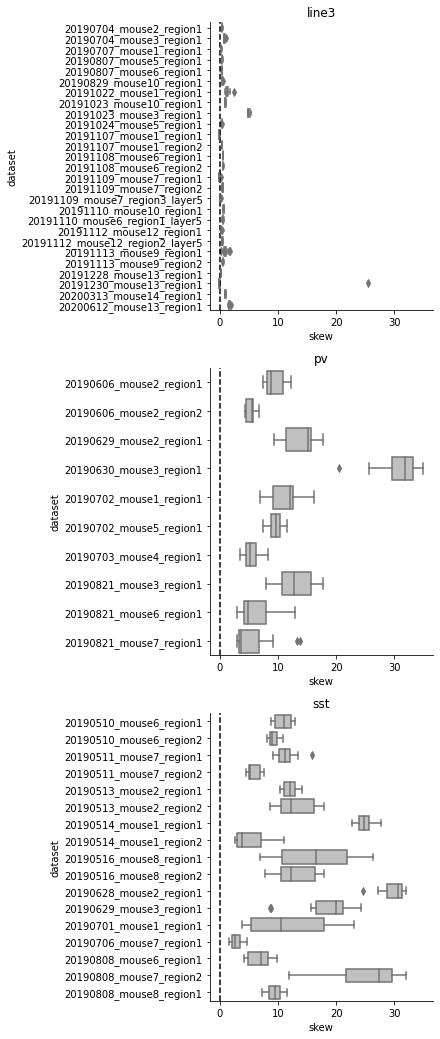

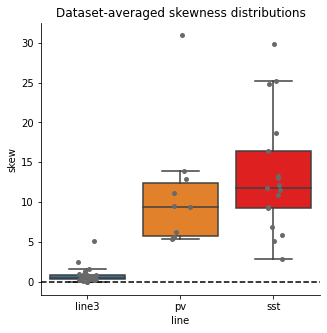

In [153]:
# Compute skewness for each ref dist
logger.info('computing skewness for each reference distribution')
skews = (ref_dists
    .groupby([Label.LINE, Label.DATASET, 'file'])
    .agg(skew)
    .rename('skew')
)

# Plot skewness distributions across lines, datasets, and runs
fig, axes = plt.subplots(len(lines), 1, figsize=(4, len(lines) * 6))
sns.despine(fig=fig)
for ax, (line, lskews) in zip(axes, skews.groupby(Label.LINE)):
    logger.info(f'plotting skewness distributions for {line} line')
    sns.boxplot(
        data=lskews.reset_index(),
        ax=ax,
        y=Label.DATASET,
        x='skew',
        color='silver',
    )
    ax.set_title(line)
    ax.axvline(0, color='k', linestyle='--')
harmonize_axes_limits(axes, axkey='x')

# Plot dataset-averaged skewness distributions across lines 
logger.info(f'plotting adatset-averaged skewness distributions across lines')
aggskews = skews.groupby([Label.LINE, Label.DATASET]).mean()
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Dataset-averaged skewness distributions')
sns.despine(ax=ax)
pltkwargs = dict(
    data=aggskews.reset_index(),
    ax=ax,
    x=Label.LINE,
    y='skew',
)
sns.boxplot(palette=Palette.LINE, showfliers=False, **pltkwargs)
sns.stripplot(color='dimgray', **pltkwargs)
ax.axhline(0, color='k', linestyle='--');

### Plot histogram distributions

In [ ]:
# for line, ldists in ref_dists.groupby(Label.LINE):
#     g = sns.displot(
#         kind='hist', 
#         data=ldists.reset_index(), 
#         x='intensity',
#         col=Label.DATASET,
#         hue=Label.RUNID,
#         col_wrap=4, 
#         height=3,
#         bins='sqrt',
#         legend='full',
#     )
#     g.set_titles('{col_name}')
#     g.fig.suptitle(f'{line} reference distributions', y=1.05)